In [125]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import LogFormatterSciNotation
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import LogFormatterMathtext
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import os
import sys
from datetime import timedelta, date
import csv
mpl.rcParams['figure.dpi'] = 300
import matplotlib.ticker as ticker

In [3]:
mpl.rcParams['figure.dpi'] = 175

In [4]:
okabe_ito = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
sns.set_context('paper')
sns.set_palette(sns.color_palette(okabe_ito))
#sns.set_palette("Set1", n_colors=9, desat=.75)

In [5]:
#https://stackoverflow.com/questions/579310/formatting-long-numbers-as-strings-in-python/49955617#49955617
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
def make_cdf(series):
    return series.value_counts(normalize=True).sort_index().cumsum()
def better_general_format(num):
    if num >= 2**7:
        return r'$2^{%s}$' % format(np.log(num)/np.log(2), 'g')
    elif num <= -(2**7):
        num = -num
        return r'-$2^{%s}$' % format(np.log(num)/np.log(2), 'g')
    num = format(num, 'g')
    return num

In [134]:
conn = sqlite3.connect("../agg-data/agg_fcc.db")
df = pd.read_sql_query("select * from agg_httpgetmt;", conn)


In [135]:
conn.close()

In [136]:
df = df[df.med_bytes_sec > 0.]


df = df[df.sum_suc > 0.]


In [137]:

df['dtime'] = pd.to_datetime(df['dtime'])
df['year'] = df['dtime'].dt.strftime('%Y')



df['med_bytes_sec'] = df['med_bytes_sec'] * 8 / (1000*1000)



In [47]:
df['yemo'] = df['dtime'].dt.strftime('%Y-%m')


In [214]:
conn_unit_profile = sqlite3.connect("../agg-data/unit-profile.db")
df_tech = pd.read_sql_query('select * from "unit-profile"', conn_unit_profile)

#fix AT&T IPBB
df_tech['technology'] = np.where(df_tech.isp == 'AT&T IPBB', 'DSL', df_tech.technology)
df_tech['technology'] = np.where(df_tech.technology == 'IPBB', 'DSL', df_tech.technology)
df_tech['technology'] = np.where(df_tech.technology == 'UVERSE', 'DSL', df_tech.technology)

def isp_names(df, column):
    df[column] = np.where(df[column].str.startswith("Verizon"), 'Verizon', df[column])
    df[column] = np.where(df[column] == "TimeWarner", 'Time Warner Cable', df[column])

    df[column] = np.where(df[column].str.startswith("Frontier"), 'Frontier', df[column])
    df[column] = np.where(df[column] == "Qwest", 'CenturyLink', df[column])
    df[column] = np.where(df[column].str.startswith("Cincinnati Bell"), 'Cincinnati Bell', df[column])
    df[column] = np.where(df[column].str.startswith("AT&T"), 'AT&T', df[column])
    df[column] = np.where(df[column] == "TWC", 'Time Warner Cable', df[column])
    
isp_names(df_tech, 'isp')

df_satellite_isps = df_tech[(df_tech.year == '2017') & (df_tech.isp.isin(['Hughes', 'Wildblue/ViaSat']))]
df_satellite_isps = df_satellite_isps[~df_satellite_isps.unit_id.isin(df_tech[df_tech.year.isin(['2019', '2018'])].unit_id.unique())]
usable_sat_units = df_satellite_isps.unit_id.unique().tolist()
usable_sat_units.remove(1273)
usable_sat_units.remove(801252)
usable_sat_units.remove(13236)
usable_sat_units.remove(999051)
usable_sat_units.remove(216686)

df_att = df_tech[(df_tech.year == '2018') & (df_tech.isp.isin(['AT&T']))]
df_att = df_att[~df_att.unit_id.isin(df_tech[df_tech.year == '2019'].unit_id.unique())]
att_probes_carry_fwd = df_att.unit_id.unique().tolist()
att_probes_carry_fwd.remove(507)
att_probes_carry_fwd.remove(5655)
att_probes_carry_fwd.remove(7460)
att_probes_carry_fwd.remove(27738)
att_probes_carry_fwd.remove(216054)
att_probes_carry_fwd.remove(216146)
att_probes_carry_fwd.remove(805166)
att_probes_carry_fwd.remove(805490)
att_probes_carry_fwd.remove(805630)
att_probes_carry_fwd.remove(805782)
att_probes_carry_fwd.remove(811954)
att_probes_carry_fwd.remove(941780)
att_probes_carry_fwd.remove(994195)
att_probes_carry_fwd.remove(994419)
att_probes_carry_fwd.remove(999719)

#Hawaiian Telcom -- remove, bought by cincinnati bell
df_hitel = df_tech[(df_tech.year == '2017') & (df_tech.isp.isin(['Hawaiian Telcom']))]
df_hitel = df_hitel[~df_hitel.unit_id.isin(df_tech[df_tech.year.isin(['2019', '2018'])].unit_id.unique())]
hit_probes_carry_fwd = df_hitel.unit_id.unique().tolist()
hit_probes_carry_fwd.remove(995125)
hit_probes_carry_fwd.remove(995121)
hit_probes_carry_fwd = []

df_tech_for_merge = pd.DataFrame()
for year in ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']:
    if year == '2012':
        df_tmp = df_tech[df_tech.year == '2012']
        df_tmp_for_append = df_tmp[df_tmp.month == '09']
        list_2012_newer_units = df_tmp_for_append.unit_id.to_list()
        list_2012_older_units = df_tmp[df_tmp.month == '04'].unit_id.to_list()
        for unit_id in list_2012_older_units:
            if not unit_id in list_2012_newer_units:
                df_tmp_for_append = pd.concat([df_tmp_for_append, df_tmp[(df_tmp.month == '04') & (df_tmp.unit_id == unit_id)]], ignore_index=True)
    elif year == '2013':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2014':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2015':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2016':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2017':
        df_tmp_for_append = df_tech[df_tech.year == year]
    elif year == '2018':
        df_tmp_for_append = df_tech[(df_tech.year == '2017') & (df_tech.unit_id.isin(usable_sat_units + hit_probes_carry_fwd))]
        df_tmp_for_append['year'] = '2018'
        df_tmp_for_append = pd.concat([df_tmp_for_append, df_tech[df_tech.year == year]], ignore_index=True)
    elif year == '2019':
        df_tmp_for_append = df_tech[(df_tech.year == '2017') & (df_tech.unit_id.isin(usable_sat_units + hit_probes_carry_fwd + att_probes_carry_fwd))]
        df_tmp_for_append['year'] = '2019'
        df_tmp_for_append = pd.concat([df_tmp_for_append, df_tech[df_tech.year == year]], ignore_index=True)
        
    df_tech_for_merge = pd.concat([df_tech_for_merge, df_tmp_for_append], ignore_index=True)

/u/home/fries/.local/lib/python3.6/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/u/home/fries/.local/lib/python3.6/site-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [169]:
df_tech_for_merge[df_tech_for_merge.year == '2019'].technology.value_counts()

DSL          1300
CABLE        1073
FIBER         753
SATELLITE     160
Name: technology, dtype: int64

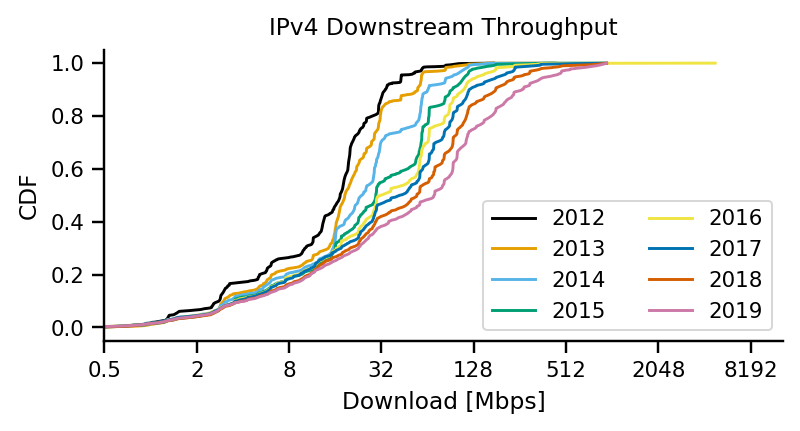

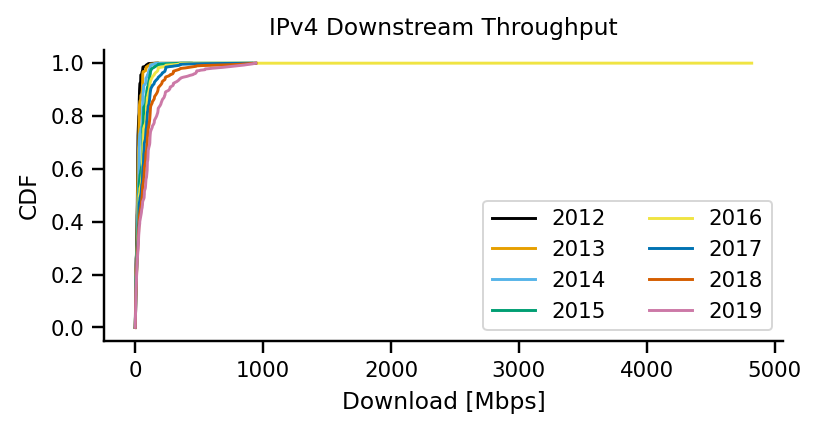

In [55]:
for log in [True, False]:
    
    fig, ax= plt.subplots(1, 1, sharex=True, figsize=(5,2.2))
    plt.rcParams['axes.formatter.min_exponent'] = 14

    if log:
        ax.set_xscale('log', basex=2)


    years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
    colors = {'2012':'C0', '2013':'C1', '2014':'C2', '2015':'C3', '2016':'C4', '2017':'C5', '2018':'C6', '2019':'C7'}
    
    lnwidth = 1.2
    mrksize = 0.

    for year in years:
        df_tmp = df[df.year == year]["med_bytes_sec"]
        if len(df_tmp) > 0:
            dfplt = make_cdf(df_tmp)
            dfplt.plot(y="med_bytes_sec", ax=ax, label=year, marker='.', markersize=mrksize, drawstyle="default", lw=lnwidth, color=colors[year])
        

        
    if log:
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: better_general_format(x)))

    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    
    if log:
        ax.legend(loc='lower right', ncol=2, markerscale=10)#, bbox_to_anchor=(.8, -.5))
    else:
        ax.legend(loc='lower right', ncol=2, markerscale=10)#, bbox_to_anchor=(.8, -.5))
    
    if log:
        ax.set_xlim(left=2**-1)
    ax.set_title("IPv4 Downstream Throughput")
    ax.set_xlabel("Download [Mbps]")
    ax.set_ylabel("CDF")

    if log:
        fig.savefig('HTTP_GET_MT/HTTP-GET-MT-CDF-IPv4-log.pdf', format='pdf', bbox_inches='tight')
    else:
        fig.savefig('HTTP_GET_MT/HTTP-GET-MT-CDF-IPv4.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [20]:
for year in ['2019']:
    df_tmp = df[df.year == year]["med_bytes_sec"]
    if len(df_tmp) > 0:
        print(year)
        print('')
        #print(df_tmp.quantile([.004]))
        #print(make_cdf(df_tmp)[0])
        #print('')
        print(df_tmp.describe(percentiles=[.003, .33, .95, .99, .75, .65], include='all'))
        #print('')
        print('')

2019

count    6.252355e+06
mean     1.087955e+02
std      1.451997e+02
min      1.600000e-05
0.3%     4.941440e-01
33%      2.543679e+01
50%      7.054765e+01
65%      1.000020e+02
75%      1.274572e+02
95%      4.048740e+02
99%      8.035892e+02
max      9.415080e+02
Name: med_bytes_sec, dtype: float64



In [210]:
for year in ['2018']:
    df_tmp = df[df.year == year]["med_bytes_sec"]
    if len(df_tmp) > 0:
        print(year)
        print('')
        print(df_tmp.quantile([.737]))
        #print(make_cdf(df_tmp)[101])
        #print(make_cdf(df_tmp)[1000])
        #print('')
        print(df_tmp.describe(percentiles=[.003, .33, .95, .99, .75, .65], include='all'))
        #print('')
        print('')

2018

0.737    100.028313
Name: med_bytes_sec, dtype: float64
count    4.677165e+06
mean     7.931209e+01
std      1.041068e+02
min      8.000000e-06
0.3%     6.082480e-01
33%      2.338338e+01
50%      5.454672e+01
65%      8.236389e+01
75%      1.011803e+02
95%      2.526692e+02
99%      4.919360e+02
max      9.442861e+02
Name: med_bytes_sec, dtype: float64



In [200]:
for year in ['2019']:
    df_tmp = df[df.year == year]["med_bytes_sec"]
    if len(df_tmp) > 0:
        print(year)
        print('')
        #print(df_tmp.quantile([.004]))
        print(make_cdf(df_tmp)[100])
        #print(make_cdf(df_tmp)[1000])
        #print('')
        print(df_tmp.describe(percentiles=[.003, .33, .95, .99, .75, .65], include='all'))
        #print('')
        print('')

2019

0.6499574960294415
count    6.252355e+06
mean     1.087955e+02
std      1.451997e+02
min      1.600000e-05
0.3%     4.941440e-01
33%      2.543679e+01
50%      7.054765e+01
65%      1.000020e+02
75%      1.274572e+02
95%      4.048740e+02
99%      8.035892e+02
max      9.415080e+02
Name: med_bytes_sec, dtype: float64



In [195]:
for year in ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']:
    df_tmp = df[df.year == year]["med_bytes_sec"]
    if len(df_tmp) > 0:
        print(year)
        print('')
        #print(df_tmp.quantile([.004]))
        #print(make_cdf(df_tmp)[0])
        #print('')
        print(df_tmp.describe(percentiles=[.003, .33, .95, .99, .75], include='all'))
        #print('')
        print('')

2012

count    3.456964e+06
mean     1.852064e+01
std      1.545117e+01
min      1.288800e-02
0.3%     5.837422e-01
33%      1.147696e+01
50%      1.723568e+01
75%      2.336017e+01
95%      4.309658e+01
99%      8.388010e+01
max      1.727915e+02
Name: med_bytes_sec, dtype: float64

2013

count    3.870289e+06
mean     2.348320e+01
std      2.055023e+01
min      4.356000e-02
0.3%     6.285669e-01
33%      1.540495e+01
50%      1.848642e+01
75%      3.041490e+01
95%      5.846825e+01
99%      1.022934e+02
max      4.412280e+02
Name: med_bytes_sec, dtype: float64

2014

count    5.453328e+06
mean     3.143257e+01
std      2.850528e+01
min      1.200000e-04
0.3%     5.793199e-01
33%      1.600492e+01
50%      2.390853e+01
75%      4.405200e+01
95%      9.265879e+01
99%      1.194081e+02
max      4.298313e+02
Name: med_bytes_sec, dtype: float64

2015

count    5.666792e+06
mean     4.194832e+01
std      3.900230e+01
min      4.240000e-04
0.3%     5.219150e-01
33%      1.714465e+01
50%    

In [196]:
print('IPv4')
for prev_year,year in [('2012', '2013'), ('2013', '2014'), ('2014', '2015'), ('2015', '2016'), ('2016', '2017'), ('2017', '2018'), ('2018', '2019')]:
    #df_tmp = df[df.year == year]["med_bytes_sec"]
    print(prev_year+'->'+year)
    incr = ((df[df.year == year]["med_bytes_sec"].quantile(0.95)/df[df.year == prev_year]["med_bytes_sec"].quantile(0.95))-1)*100
    print(str(incr)+"%")
    


IPv4
2012->2013
35.66794064234884%
2013->2014
58.47711804191542%
2014->2015
21.873488351797697%
2015->2016
21.324709553350594%
2016->2017
37.58840052572736%
2017->2018
34.037201641709025%
2018->2019
60.23876428827823%
IPv6
2014->2015
49.25397279731642%
2015->2016
11.075417088698947%
2016->2017
33.32748535014558%
2017->2018
33.62133082785592%
2018->2019
50.52220183040275%


In [197]:
print('IPv4')
for prev_year,year in [('2012', '2013'), ('2013', '2014'), ('2014', '2015'), ('2015', '2016'), ('2016', '2017'), ('2017', '2018'), ('2018', '2019')]:
    #df_tmp = df[df.year == year]["med_bytes_sec"]
    print(prev_year+'->'+year)
    incr = ((df[df.year == year]["med_bytes_sec"].quantile(0.8)/df[df.year == prev_year]["med_bytes_sec"].quantile(0.8))-1)*100
    print(str(incr)+"%")
    


IPv4
2012->2013
12.41870742559723%
2013->2014
80.47725381844172%
2014->2015
15.133517974530886%
2015->2016
28.685694305194765%
2016->2017
11.555279205802282%
2017->2018
22.509467599927003%
2018->2019
45.25221529911323%
IPv6
2014->2015
28.913973514621617%
2015->2016
25.501253783161815%
2016->2017
30.410497809576587%
2017->2018
48.895886731542305%
2018->2019
56.49434195329657%


In [215]:
df_new = df[df.year == '2019'].merge(df_tech_for_merge[df_tech_for_merge.year == '2019'], on = 'unit_id')

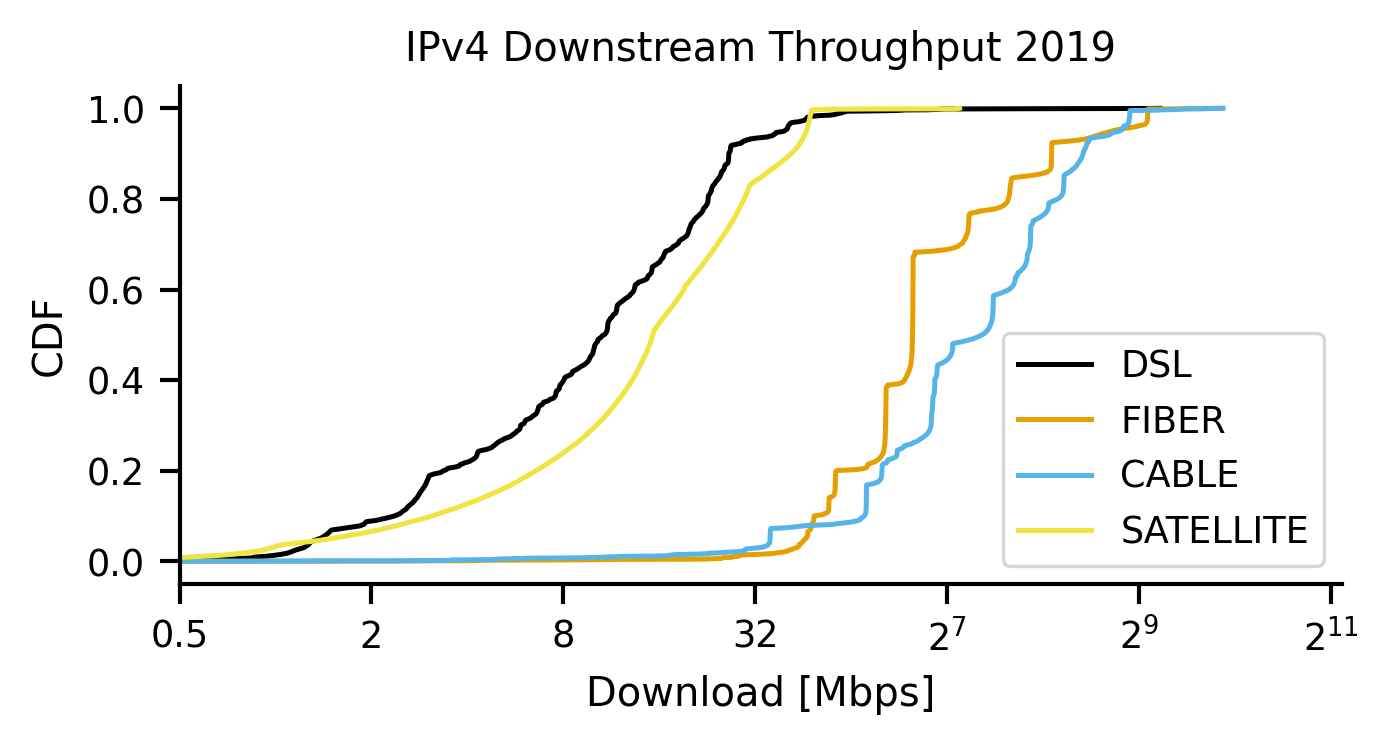

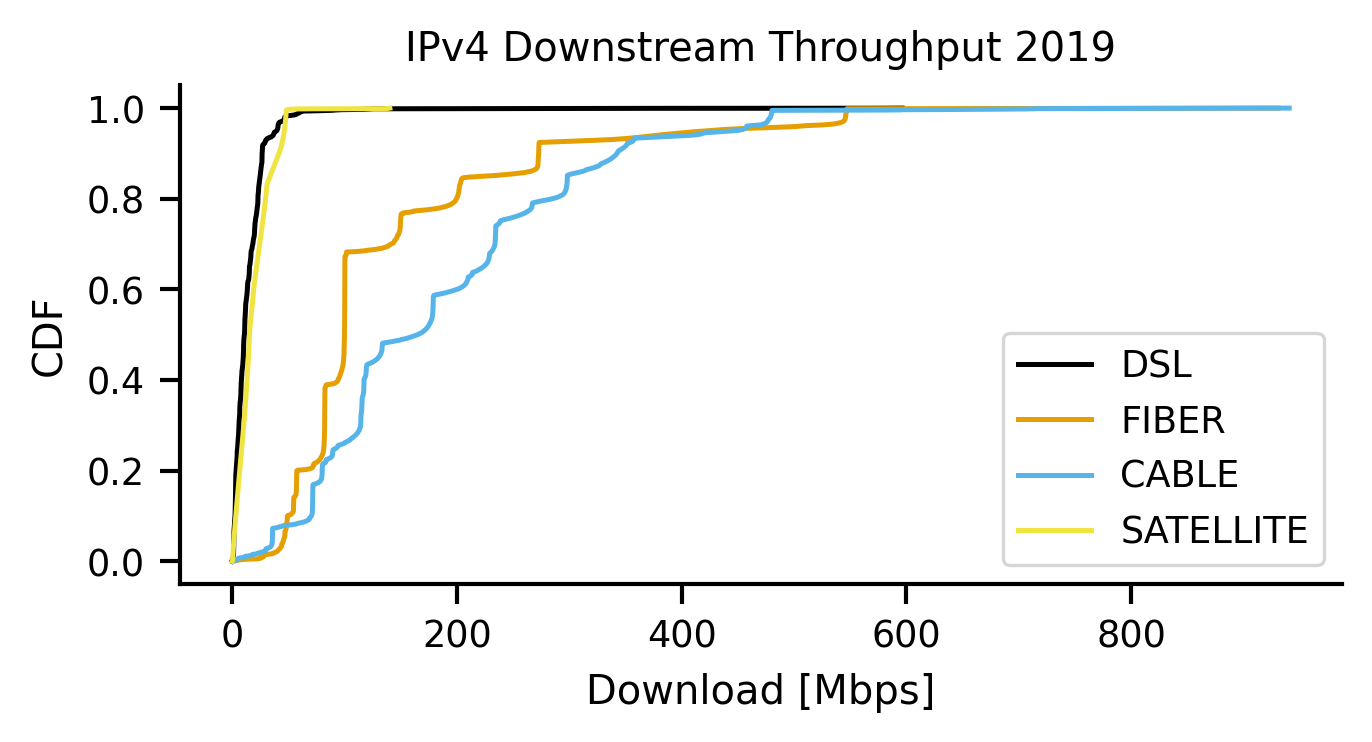

In [186]:
for log in [True, False]:
    
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5,2.2))
    plt.rcParams['axes.formatter.min_exponent'] = 14

    if log:
        ax.set_xscale('log', basex=2)


    techs = ['DSL', 'FIBER', 'CABLE', 'IPBB', 'SATELLITE']
    colors = {'DSL':'C0', 'FIBER':'C1', 'CABLE':'C2', 'IPBB':'C3', 'SATELLITE':'C4'}
    
    lnwidth = 1.2
    mrksize = 0.

    for tech in techs:
        df_tmp = df_new[df_new.technology == tech]["med_bytes_sec"]
        if len(df_tmp) > 0:
            dfplt = make_cdf(df_tmp)
            dfplt.plot(y="med_bytes_sec", ax=ax, label=tech, marker='.', markersize=mrksize, drawstyle="default", lw=lnwidth, color=colors[tech])
        

        
    if log:
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: better_general_format(x)))

    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    
    if log:
        ax.legend(loc='lower right', ncol=1, markerscale=10)#, bbox_to_anchor=(.8, -.5))
    else:
        ax.legend(loc='lower right', ncol=1, markerscale=10)#, bbox_to_anchor=(.8, -.5))
    
    if log:
        ax.set_xlim(left=2**-1)
    
    ax.set_title("IPv4 Downstream Throughput 2019")
    ax.set_xlabel("Download [Mbps]")
    ax.set_ylabel("CDF")

    if log:
        fig.savefig('HTTP_GET_MT/HTTP-GET-MT-CDF-by-ACCESSTECH-IPv4-log.pdf', format='pdf', bbox_inches='tight')
    else:
        fig.savefig('HTTP_GET_MT/HTTP-GET-MT-CDF-by-ACCESSTECH-IPv4.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [217]:
for tech in ['DSL', 'FIBER', 'CABLE', 'SATELLITE']:
    df_tmp = df_new[df_new.technology == tech]["med_bytes_sec"]
    if len(df_tmp) > 0:
        print(tech)
        print('')
        #print(df_tmp.quantile([.004]))
        #print(make_cdf(df_tmp))
        #print('')
        print(df_tmp.describe(percentiles=[.003, .33, .95, .99, .75], include='all'))
        #print('')
        print('')

DSL

count    1.183238e+06
mean     1.438496e+01
std      1.910038e+01
min      3.200000e-05
0.3%     5.696674e-01
33%      6.626632e+00
50%      1.073476e+01
75%      2.048422e+01
95%      3.951474e+01
99%      5.979787e+01
max      5.962522e+02
Name: med_bytes_sec, dtype: float64

FIBER

count    588640.000000
mean        138.480304
std         116.351307
min           0.019672
0.3%          9.499898
33%          82.305408
50%          99.859576
75%         149.804148
95%         422.994484
99%         546.561128
max         931.208640
Name: med_bytes_sec, dtype: float64

CABLE

count    982762.000000
mean        184.116545
std         118.377743
min           0.000580
0.3%          3.561256
33%         114.982627
50%         165.046798
75%         238.436946
95%         447.352203
99%         480.132793
max         940.787776
Name: med_bytes_sec, dtype: float64

SATELLITE

count    68648.000000
mean        18.822851
std         14.000928
min          0.002392
0.3%         0.204463
3

In [22]:
weird_unit_ids = [   1273,   12893,   13236,   32384,   32385,   32403,   32419,
        216686,  605674,  614120,  614134,  614184,  615144,  615152,
        620744,  801248,  801252,  806268,  915802,  939188,  940672,
        941610,  941612,  941776,  941934,  942262,  942528,  942536,
        942596,  943290,  948134,  948956,  949082,  949158,  998005,
        998015,  998025,  998035,  998053,  998339,  998343,  998345,
        998373,  998807,  999005,  999051, 1009534, 1009996, 1006964]
weird_unit_ids_with_lots_of_results = [1273, 13236, 216686, 620744, 801252, 942262, 999051]

In [23]:
df_new[df_new.unit_id.isin(weird_unit_ids_with_lots_of_results)].groupby('unit_id', as_index=False).agg({'med_bytes_sec':'median', 'download':'first'})

,unit_id,med_bytes_sec,download
0,1273,22.175936,12
1,13236,7.394840,12
2,216686,5.847268,12
3,620744,18.994680,10
4,801252,54.498936,5
5,942262,54.998128,10
6,999051,93.738506,5


In [42]:
df_satellite_isps = df_tech[(df_tech.year == '2017') & (df_tech.isp.isin(['Hughes', 'Wildblue/ViaSat']))]

In [49]:
satellite_unit_ids = df_satellite_isps.unit_id.unique().tolist()

In [50]:
df_tech[(df_tech.year == '2018') & (df_tech.unit_id.isin(satellite_unit_ids))]

,unit_id,isp,download,upload,technology,state,region,tz_offset,tz_offset_dst,year,month


In [51]:
df_tech[(df_tech.year == '2019') & (df_tech.unit_id.isin(satellite_unit_ids))]

,unit_id,isp,download,upload,technology,state,region,tz_offset,tz_offset_dst,year,month
11606,942262,Comcast,60.0,5.0,CABLE,PA,NORTHEAST,-5.0,-4.0,2019,09


In [52]:
for swapped_to_non_sat in df_tech[(df_tech.year == '2019') & (df_tech.unit_id.isin(satellite_unit_ids))].unit_id.unique():
    satellite_unit_ids.remove(swapped_to_non_sat)

In [58]:
df_sat_carry_metadata_forward = df[(df.year.isin(['2019', '2018', '2017'])) & (df.unit_id.isin(satellite_unit_ids))].merge(df_tech[df_tech.year == '2017'], on='unit_id')
df_6_sat_carry_metadata_forward = df_6[(df_6.year.isin(['2019', '2018', '2017'])) & (df_6.unit_id.isin(satellite_unit_ids))].merge(df_tech[df_tech.year == '2017'], on='unit_id')

df_yearly_med = df_sat_carry_metadata_forward.groupby(['unit_id', 'year_x'], as_index=False).agg({'download':'first', 'med_bytes_sec':'median'})
df_yearly_med.download = pd.to_numeric(df_yearly_med.download)
df_17_18 = df_yearly_med[df_yearly_med.year_x == '2017'].merge(df_yearly_med[df_yearly_med.year_x == '2018'], on='unit_id')
df_17_18['delta'] = df_17_18.med_bytes_sec_y - df_17_18.med_bytes_sec_x

df_18_19 = df_yearly_med[df_yearly_med.year_x == '2018'].merge(df_yearly_med[df_yearly_med.year_x == '2019'], on='unit_id')
df_18_19['delta'] = df_18_19.med_bytes_sec_y - df_18_19.med_bytes_sec_x

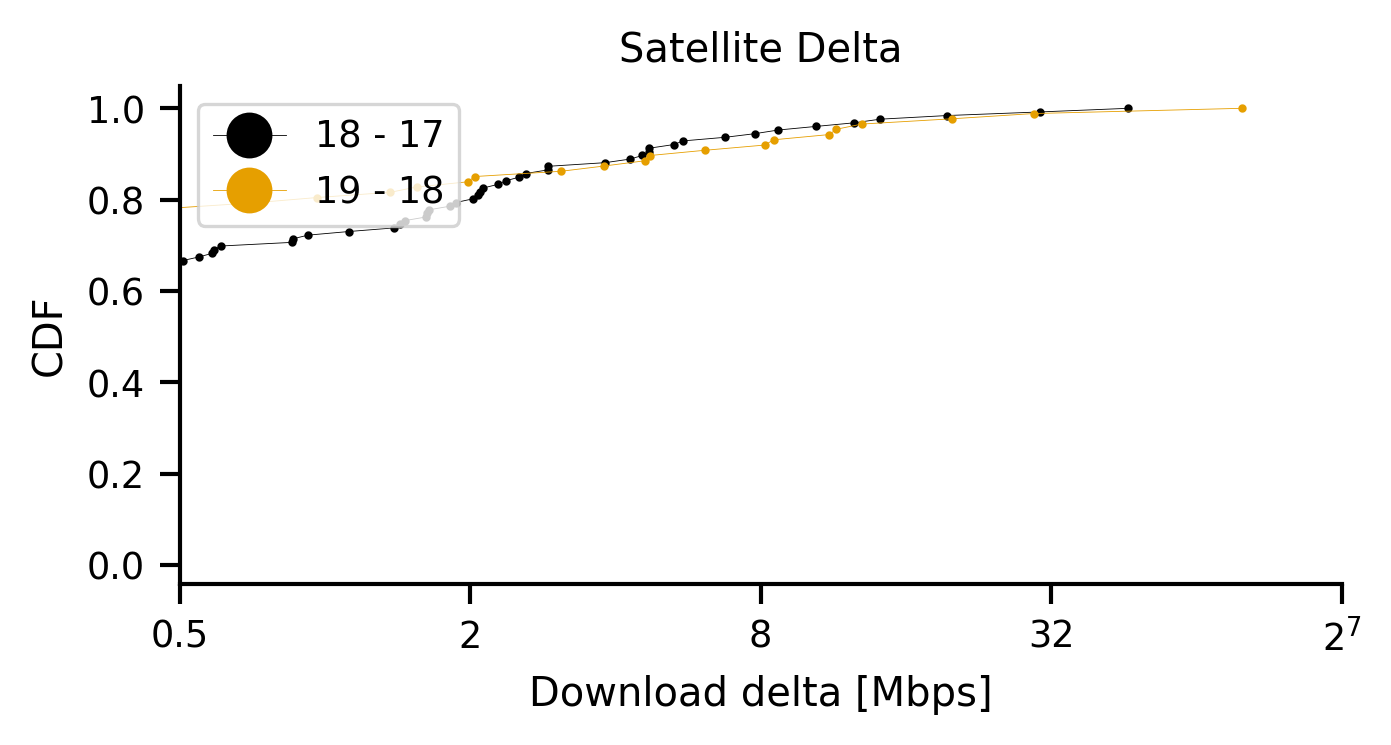

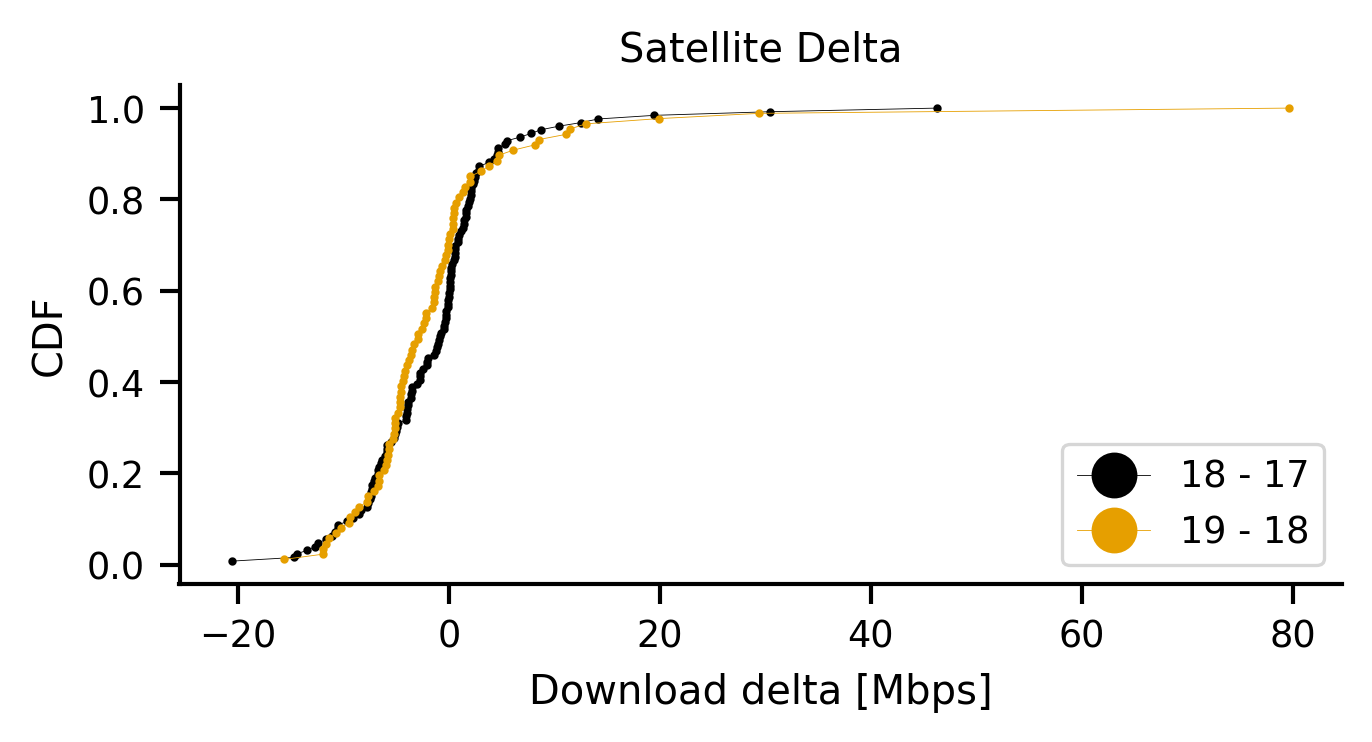

In [87]:
for log in [True, False]:
    
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5,2.2))
    plt.rcParams['axes.formatter.min_exponent'] = 14
    #fig.subplots_adjust(hspace=.3)
    #fig = plt.figure(figsize=(10,2))
    #fig.subplots_adjust(hspace=0.3)#, wspace=0.4)
    #ax = axs[0] #= fig.add_subplot(121)
    #ax2 = axs[1] #= fig.add_subplot(122, sharey=ax, sharex=ax)
    if log:
        ax.set_xscale('log', basex=2)
        ax2.set_xscale('log', basex=2)
    
    lnwidth = 0.2
    mrksize = 2

    dfplt = make_cdf(df_17_18['delta'])
    dfplt.plot(y="delta", ax=ax, label='18 - 17', marker='.', markersize=mrksize, drawstyle="default", lw=lnwidth)
    
    dfplt = make_cdf(df_18_19['delta'])
    dfplt.plot(y="delta", ax=ax, label='19 - 18', marker='.', markersize=mrksize, drawstyle="default", lw=lnwidth)
        

        #df_tmp = df_6_new[df_6_new.technology == tech]["med_bytes_sec"]
        #if len(df_tmp) > 0:
        #    dfplt = make_cdf(df_tmp)
        #    dfplt.plot(y="med_bytes_sec", ax=ax2, label=tech, marker='.', markersize=mrksize, drawstyle="default", lw=lnwidth, color=colors[tech])

        
    if log:
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: better_general_format(x)))
        #ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: better_general_format(x)))
        #ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        #ax2.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        #ax.xaxis.set_major_formatter(LogFormatterMathtext(base=2))
        #ax2.xaxis.set_major_formatter(LogFormatterMathtext(base=2))

    
    #ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: human_format(x)))
    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    
    if log:
        ax.legend(loc='upper left', ncol=1, markerscale=10)#, bbox_to_anchor=(.8, -.5))
    else:
        ax.legend(loc='lower right', ncol=1, markerscale=10)#, bbox_to_anchor=(.8, -.5))
    
    if log:
        ax.set_xlim(left=2**-1)
    
    ax.set_title("Satellite Delta")
    ax.set_xlabel("Download delta [Mbps]")
    ax.set_ylabel("CDF")
    '''
    ax2.spines['right'].set_color('none')
    ax2.spines['top'].set_color('none')
    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.spines['bottom'].set_position(('axes', -0.0))
    ax2.spines['left'].set_position(('axes', -0.0))

    
    ax2.set_title("IPv6 Downstream Throughput 2019")
    
    
    ax2.set_xlabel("Download [Mbps]")

    
    ax2.set_ylabel("CDF")
'''
    #if log:
    #    fig.savefig('HTTP_GET_MT/HTTP-GET-MT-CDF-by-ACCESSTECH-IPv6-no-Satellite-log.pdf', format='pdf', bbox_inches='tight')
    #else:
    #    fig.savefig('HTTP_GET_MT/HTTP-GET-MT-CDF-by-ACCESSTECH-IPv6-no-Satellite.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [79]:
df_18_19[(df_18_19.delta > 15) | (df_18_19.delta < -15)]

,unit_id,year_x_x,download_x,med_bytes_sec_x,year_x_y,download_y,med_bytes_sec_y,delta
26,799152,2018,25,42.826062,2019,25,27.167164,-15.658898
29,801252,2018,5,25.074016,2019,5,54.498936,29.424920
42,941990,2018,5,15.045972,2019,5,34.966872,19.920900
79,999051,2018,5,14.104968,2019,5,93.738506,79.633538


In [80]:
df_17_18[(df_17_18.delta > 15) | (df_17_18.delta < -15)]

,unit_id,year_x_x,download_x,med_bytes_sec_x,year_x_y,download_y,med_bytes_sec_y,delta
4,12893,2017,25,1.271112,2018,25,47.523724,46.252612
39,799152,2017,25,23.356112,2018,25,42.826062,19.469950
44,806268,2017,25,4.444888,2018,25,34.847844,30.402956
90,998019,2017,25,46.887788,2018,25,26.376770,-20.511018


In [81]:
# 12893, 806268 receives way less download than expected in 2017 and way more in 2018
# 998019 is the opposite of above
# 799152 increases to way above average in 2018 and then decreases to expected again in 2019
# 801252, 941990, 999051 all have above average speeds, so their metadata is likely not accurate

In [85]:
usable_sat_units = df_18_19[(df_18_19.delta < 15) & (df_18_19.delta > -15)].unit_id.unique().tolist()

In [86]:
usable_sat_units

[605,
 1273,
 12893,
 13236,
 32384,
 32385,
 32403,
 32419,
 32548,
 216686,
 589792,
 605674,
 614078,
 614120,
 614134,
 614184,
 614196,
 614220,
 615144,
 615152,
 615366,
 620744,
 620750,
 623976,
 623992,
 797804,
 799496,
 801248,
 806268,
 915802,
 939188,
 939190,
 940672,
 941604,
 941610,
 941612,
 941776,
 941934,
 941972,
 941988,
 942528,
 942536,
 942596,
 942632,
 942654,
 943274,
 943290,
 945144,
 948134,
 948956,
 949030,
 949082,
 949084,
 949158,
 997489,
 997989,
 997993,
 998005,
 998015,
 998019,
 998025,
 998035,
 998039,
 998045,
 998053,
 998339,
 998343,
 998345,
 998373,
 998783,
 998807,
 998997,
 999003,
 999005,
 999017,
 999019,
 1006420,
 1006964,
 1009114,
 1009360,
 1009388,
 1009534,
 1009996]

In [88]:
#consistently has less than 500ms latency in 2019
usable_sat_units.remove(1273)

In [89]:
usable_sat_units

[605,
 12893,
 13236,
 32384,
 32385,
 32403,
 32419,
 32548,
 216686,
 589792,
 605674,
 614078,
 614120,
 614134,
 614184,
 614196,
 614220,
 615144,
 615152,
 615366,
 620744,
 620750,
 623976,
 623992,
 797804,
 799496,
 801248,
 806268,
 915802,
 939188,
 939190,
 940672,
 941604,
 941610,
 941612,
 941776,
 941934,
 941972,
 941988,
 942528,
 942536,
 942596,
 942632,
 942654,
 943274,
 943290,
 945144,
 948134,
 948956,
 949030,
 949082,
 949084,
 949158,
 997489,
 997989,
 997993,
 998005,
 998015,
 998019,
 998025,
 998035,
 998039,
 998045,
 998053,
 998339,
 998343,
 998345,
 998373,
 998783,
 998807,
 998997,
 999003,
 999005,
 999017,
 999019,
 1006420,
 1006964,
 1009114,
 1009360,
 1009388,
 1009534,
 1009996]

In [ ]:

df_sat_latency = df[(df.year.isin(['2019', '2018', '2017'])) & (df.unit_id.isin(usable_sat_units))]#.merge(df_tech[df_tech.year == '2019'], on = 'unit_id')


for probe_id in usable_sat_units:
    print('---')
    print(probe_id)

    df_ipv4_count = df_sat_latency[df_sat_latency.unit_id == probe_id].groupby('dtime',as_index=False).size().reset_index(name='IPv4')
    
    df_ipv4_count.dtime = pd.to_datetime(df_ipv4_count.dtime)
    df_ipv4_count.set_index('dtime')
    


    

    
    ax = df_ipv4_count.plot(x='dtime', y='IPv4', marker=".", markersize=3, drawstyle="default", lw=0)

    
    ax.set_title('Probe ID: ' + str(probe_id)+ ' ' + df_satellite_isps[df_satellite_isps.unit_id == probe_id].isp.tolist()[0])
    plt.show()

In [108]:
df_att = df_tech[(df_tech.year == '2018') & (df_tech.isp.isin(['AT&T']))]

In [109]:
df_att17 = df_tech[(df_tech.year == '2017') & (df_tech.isp.isin(['AT&T']))]

In [110]:
df_att17[df_att17.unit_id.isin(df_att.unit_id.unique())]

,unit_id,isp,download,upload,technology,state,region,tz_offset,tz_offset_dst,year,month
757,940766,AT&T,5,0.768,DSL,OH,MIDWEST,-5.0,-4.0,2017,09
976,27786,AT&T,3,1,DSL,OH,MIDWEST,-5.0,-4.0,2017,09
997,1006390,AT&T,3,0.768,DSL,IN,MIDWEST,-5.0,-4.0,2017,09
1064,994185,AT&T,3,1,DSL,KY,SOUTH,-5.0,-4.0,2017,09
1111,994221,AT&T,3,1,DSL,TN,SOUTH,-5.0,-4.0,2017,09
...,...,...,...,...,...,...,...,...,...,...,...
1963,805630,AT&T,18,1.5,DSL,NC,SOUTH,-5.0,-4.0,2017,09
1965,999815,AT&T,18,1.5,DSL,MO,MIDWEST,-6.0,-5.0,2017,09
2037,11123,AT&T,24,3,DSL,OH,MIDWEST,-5.0,-4.0,2017,09
2185,26431,AT&T,24,3,DSL,GA,SOUTH,-5.0,-4.0,2017,09


In [111]:
len(df_att)

174

In [112]:
df_tech[(df_tech.unit_id.isin(df_att.unit_id.unique())) & (df_tech.year != '2018') & (df_tech.isp != 'AT&T')].sort_values('year')

,unit_id,isp,download,upload,technology,state,region,tz_offset,tz_offset_dst,year,month
25356,32549,Wildblue/ViaSat,12,3,SATELLITE,KY,SOUTH,-5.0,-4.0,2012,09
43282,7460,Clearwire,12.0,1.0,WIRELESS,IL,MIDWEST,-6.0,-5.0,2012,04
44259,8969,Charter,30.0,4.0,CABLE,MO,MIDWEST,-6.0,-5.0,2012,04
22160,11123,Time Warner Cable,10,1,CABLE,OH,MIDWEST,-5.0,-4.0,2012,09
21006,8969,Charter,15,3,CABLE,MO,MIDWEST,-6.0,-5.0,2012,09
45594,11123,Time Warner Cable,10.0,1.0,CABLE,OH,MIDWEST,-5.0,-4.0,2012,04
10584,32549,Wildblue/ViaSat,12,3,SATELLITE,KY,SOUTH,-5.0,-4.0,2013,09
9292,11123,Time Warner Cable,15,1,CABLE,OH,MIDWEST,-5.0,-4.0,2013,09
37257,32549,Wildblue/ViaSat,12,3,SATELLITE,KY,SOUTH,-5.0,-4.0,2014,09
37929,8969,Comcast,50,10,CABLE,MO,MIDWEST,-6.0,-5.0,2014,09


In [113]:
df_tech[df_tech.unit_id == 999341]

,unit_id,isp,download,upload,technology,state,region,tz_offset,tz_offset_dst,year,month
501,999341,Windstream,12,0.768,DSL,GA,SOUTH,-5.0,-4.0,2017,09
26961,999341,AT&T,6,0.512,DSL,GA,SOUTH,-5.0,-4.0,2018,09


In [119]:
df_tech[df_tech.unit_id == 32549].sort_values('year')

,unit_id,isp,download,upload,technology,state,region,tz_offset,tz_offset_dst,year,month
25356,32549,Wildblue/ViaSat,12,3,SATELLITE,KY,SOUTH,-5.0,-4.0,2012,09
10584,32549,Wildblue/ViaSat,12,3,SATELLITE,KY,SOUTH,-5.0,-4.0,2013,09
37257,32549,Wildblue/ViaSat,12,3,SATELLITE,KY,SOUTH,-5.0,-4.0,2014,09
28825,32549,AT&T,12,1,DSL,KY,SOUTH,-5.0,-4.0,2015,09
15897,32549,AT&T,6,0.768,DSL,KY,SOUTH,NaN,NaN,2016,09
1304,32549,AT&T,6,0.768,DSL,KY,SOUTH,-5.0,-4.0,2017,09
25915,32549,AT&T,6,0.768,DSL,KY,SOUTH,-5.0,-4.0,2018,09


In [ ]:
df_tech[df_tech.unit_id == 32549]

In [114]:
df[df.unit_id == 999341].year.unique()

array(['2017', '2018', '2019'], dtype=object)

In [115]:
df_att = df_att[~df_att.unit_id.isin(df_tech[df_tech.year == '2019'].unit_id.unique())]

In [116]:
len(df_att)

172

In [120]:
att_probes_carry_fwd = df_att.unit_id.unique().tolist()

In [124]:
att_probes_carry_fwd

[507,
 563,
 790,
 1087,
 1203,
 5596,
 5616,
 5655,
 5757,
 5842,
 6129,
 6305,
 7179,
 7226,
 7416,
 7460,
 7826,
 8375,
 8807,
 8969,
 9290,
 9598,
 9616,
 9953,
 10037,
 10610,
 10793,
 10910,
 10911,
 11123,
 11366,
 11524,
 13412,
 26431,
 27698,
 27738,
 27786,
 28761,
 32549,
 184442,
 193026,
 210406,
 210450,
 215698,
 216054,
 216146,
 217190,
 605662,
 615112,
 623956,
 625876,
 625882,
 625932,
 636350,
 660294,
 669074,
 797592,
 798324,
 798724,
 805054,
 805056,
 805166,
 805270,
 805276,
 805280,
 805292,
 805296,
 805384,
 805490,
 805504,
 805538,
 805558,
 805630,
 805634,
 805760,
 805778,
 805782,
 805804,
 805874,
 805912,
 805950,
 805960,
 805976,
 805996,
 806086,
 806090,
 806096,
 806186,
 806256,
 806278,
 806282,
 806290,
 806298,
 806300,
 806330,
 811882,
 811954,
 811982,
 882106,
 915624,
 925818,
 939602,
 940766,
 941698,
 941780,
 942636,
 945120,
 948526,
 990695,
 994185,
 994195,
 994203,
 994205,
 994209,
 994221,
 994235,
 994249,
 994419,
 994

In [ ]:

df_att_dl = df[(df.year.isin(['2019', '2018'])) & (df.unit_id.isin(att_probes_carry_fwd))]#.merge(df_tech[df_tech.year == '2019'], on = 'unit_id')


for probe_id in att_probes_carry_fwd:
    print('---')
    print(probe_id)

    df_ipv4_count = df_att_dl[df_att_dl.unit_id == probe_id].groupby('dtime',as_index=False).size().reset_index(name='IPv4')
    
    df_ipv4_count.dtime = pd.to_datetime(df_ipv4_count.dtime)
    df_ipv4_count.set_index('dtime')
    

    
    ax = df_ipv4_count.plot(x='dtime', y='IPv4', marker=".", markersize=3, drawstyle="default", lw=0)

    ax.set_title('Probe ID: ' + str(probe_id)+ ' ' + df_att[df_att.unit_id == probe_id].isp.tolist()[0])
    plt.show()

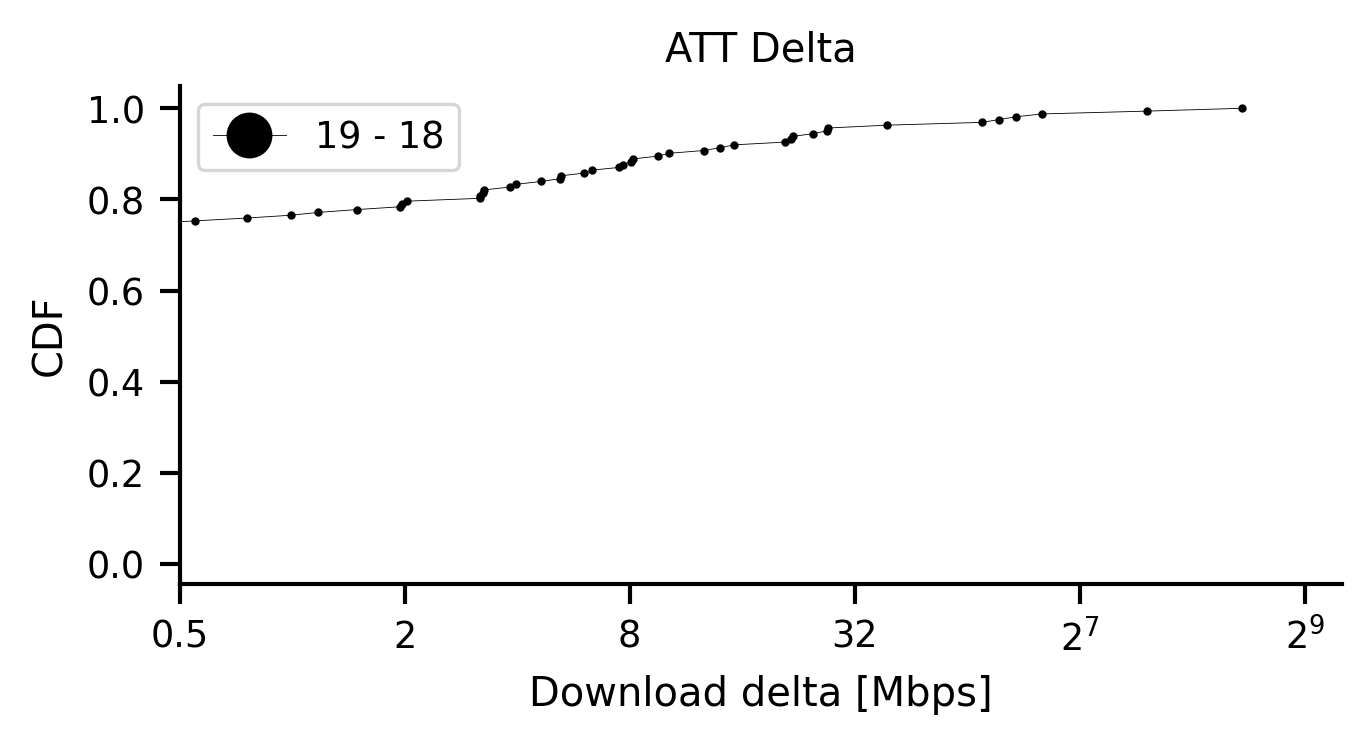

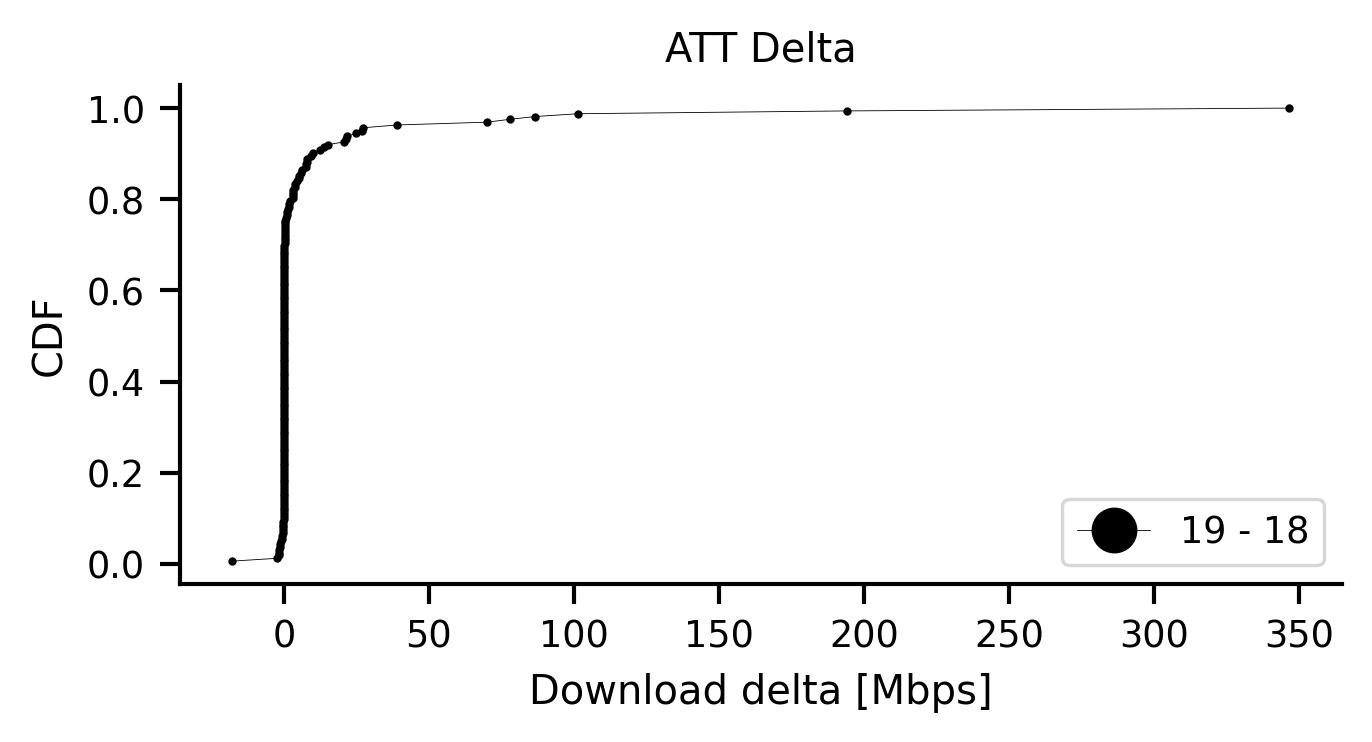

In [147]:
df_att_carry_metadata_forward = df[(df.year.isin(['2019', '2018'])) & (df.unit_id.isin(att_probes_carry_fwd))].merge(df_tech[df_tech.year == '2018'], on='unit_id')
df_yearly_med_att = df_att_carry_metadata_forward.groupby(['unit_id', 'year_x'], as_index=False).agg({'download':'first', 'med_bytes_sec':'median'})
df_yearly_med_att.download = pd.to_numeric(df_yearly_med_att.download)


df_18_19 = df_yearly_med_att[df_yearly_med_att.year_x == '2018'].merge(df_yearly_med_att[df_yearly_med_att.year_x == '2019'], on='unit_id')
df_18_19['delta'] = df_18_19.med_bytes_sec_y - df_18_19.med_bytes_sec_x


for log in [True, False]:
    
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5,2.2))
    plt.rcParams['axes.formatter.min_exponent'] = 14
    #fig.subplots_adjust(hspace=.3)
    #fig = plt.figure(figsize=(10,2))
    #fig.subplots_adjust(hspace=0.3)#, wspace=0.4)
    #ax = axs[0] #= fig.add_subplot(121)
    #ax2 = axs[1] #= fig.add_subplot(122, sharey=ax, sharex=ax)
    if log:
        ax.set_xscale('log', basex=2)
    
    lnwidth = 0.2
    mrksize = 2

    #dfplt = make_cdf(df_17_18['delta'])
    #dfplt.plot(y="delta", ax=ax, label='18 - 17', marker='.', markersize=mrksize, drawstyle="default", lw=lnwidth)
    
    dfplt = make_cdf(df_18_19['delta'])
    dfplt.plot(y="delta", ax=ax, label='19 - 18', marker='.', markersize=mrksize, drawstyle="default", lw=lnwidth)
        

        #df_tmp = df_6_new[df_6_new.technology == tech]["med_bytes_sec"]
        #if len(df_tmp) > 0:
        #    dfplt = make_cdf(df_tmp)
        #    dfplt.plot(y="med_bytes_sec", ax=ax2, label=tech, marker='.', markersize=mrksize, drawstyle="default", lw=lnwidth, color=colors[tech])

        
    if log:
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: better_general_format(x)))
        #ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: better_general_format(x)))
        #ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        #ax2.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        #ax.xaxis.set_major_formatter(LogFormatterMathtext(base=2))
        #ax2.xaxis.set_major_formatter(LogFormatterMathtext(base=2))

    
    #ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: human_format(x)))
    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    
    if log:
        ax.legend(loc='upper left', ncol=1, markerscale=10)#, bbox_to_anchor=(.8, -.5))
    else:
        ax.legend(loc='lower right', ncol=1, markerscale=10)#, bbox_to_anchor=(.8, -.5))
    
    if log:
        ax.set_xlim(left=2**-1)
    
    ax.set_title("ATT Delta")
    ax.set_xlabel("Download delta [Mbps]")
    ax.set_ylabel("CDF")
    '''
    ax2.spines['right'].set_color('none')
    ax2.spines['top'].set_color('none')
    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.spines['bottom'].set_position(('axes', -0.0))
    ax2.spines['left'].set_position(('axes', -0.0))

    
    ax2.set_title("IPv6 Downstream Throughput 2019")
    
    
    ax2.set_xlabel("Download [Mbps]")

    
    ax2.set_ylabel("CDF")
'''
    #if log:
    #    fig.savefig('HTTP_GET_MT/HTTP-GET-MT-CDF-by-ACCESSTECH-IPv6-no-Satellite-log.pdf', format='pdf', bbox_inches='tight')
    #else:
    #    fig.savefig('HTTP_GET_MT/HTTP-GET-MT-CDF-by-ACCESSTECH-IPv6-no-Satellite.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [149]:
df_18_19[(df_18_19.delta > 15) | (df_18_19.delta < -15)].sort_values('delta')

,unit_id,year_x_x,download_x,med_bytes_sec_x,year_x_y,download_y,med_bytes_sec_y,delta
41,216146,2018,18,22.772636,2019,18,5.038788,-17.733848
6,5655,2018,6,7.593272,2019,6,22.771544,15.178272
64,805490,2018,6,7.585104,2019,6,28.461566,20.876462
32,27738,2018,6,7.605952,2019,6,29.219624,21.613672
68,805630,2018,18,22.796306,2019,18,44.675836,21.879530
71,805782,2018,3,3.766332,2019,3,28.515316,24.748984
142,999719,2018,18,22.775560,2019,18,49.816860,27.041300
14,7460,2018,18,22.744732,2019,18,49.970548,27.225816
98,941780,2018,18,22.711494,2019,18,61.671850,38.960356
90,811954,2018,18,22.788288,2019,18,92.860016,70.071728


In [154]:
df_18_19[(df_18_19.delta > 15) | (df_18_19.delta < -15)].unit_id.unique().tolist()

[507,
 5655,
 7460,
 27738,
 216054,
 216146,
 805166,
 805490,
 805630,
 805782,
 811954,
 941780,
 994195,
 994419,
 999719]

In [150]:
#probably changed to some other isp/tech, massive increase in download speeds
att_probes_carry_fwd_dl_filter = df_18_19[(df_18_19.delta < 15) & (df_18_19.delta > -15)].unit_id.unique().tolist()



In [152]:
att_probes_carry_fwd_dl_filter

[563,
 790,
 1087,
 1203,
 5596,
 5757,
 5842,
 6129,
 6305,
 7179,
 7226,
 7416,
 7826,
 8375,
 8807,
 8969,
 9290,
 9598,
 9616,
 10037,
 10610,
 10910,
 10911,
 11123,
 11366,
 11524,
 13412,
 26431,
 27698,
 27786,
 28761,
 32549,
 184442,
 210406,
 210450,
 215698,
 217190,
 605662,
 615112,
 623956,
 625876,
 625882,
 625932,
 636350,
 660294,
 669074,
 797592,
 798324,
 798724,
 805054,
 805056,
 805270,
 805276,
 805280,
 805292,
 805296,
 805384,
 805504,
 805538,
 805558,
 805760,
 805778,
 805804,
 805874,
 805912,
 805950,
 805960,
 805976,
 805996,
 806086,
 806090,
 806096,
 806186,
 806256,
 806278,
 806282,
 806298,
 806300,
 806330,
 811882,
 811982,
 882106,
 915624,
 925818,
 939602,
 940766,
 941698,
 942636,
 945120,
 948526,
 990695,
 994185,
 994203,
 994205,
 994209,
 994221,
 994235,
 994617,
 994659,
 994667,
 994669,
 994675,
 998815,
 999075,
 999085,
 999091,
 999105,
 999107,
 999109,
 999117,
 999121,
 999125,
 999129,
 999133,
 999197,
 999293,
 999331,


In [160]:
#Hawaiian Telcom
df_hitel = df_tech[(df_tech.year == '2017') & (df_tech.isp.isin(['Hawaiian Telcom']))]
df_hitel

,unit_id,isp,download,upload,technology,state,region,tz_offset,tz_offset_dst,year,month
908,999601,Hawaiian Telcom,11,1,DSL,HI,WEST,-10.0,-10.0,2017,09
924,1000035,Hawaiian Telcom,7,1,DSL,HI,WEST,-10.0,-10.0,2017,09
952,999199,Hawaiian Telcom,7,1,DSL,HI,WEST,-10.0,-10.0,2017,09
981,999469,Hawaiian Telcom,7,1,DSL,HI,WEST,-10.0,-10.0,2017,09
992,658444,Hawaiian Telcom,11,1,DSL,HI,WEST,-10.0,-10.0,2017,09
1001,999179,Hawaiian Telcom,7,1,DSL,HI,WEST,-10.0,-10.0,2017,09
1020,658454,Hawaiian Telcom,7,1,DSL,HI,WEST,-10.0,-10.0,2017,09
1048,995125,Hawaiian Telcom,7,1,DSL,HI,WEST,-10.0,-10.0,2017,09
1050,999451,Hawaiian Telcom,7,1,DSL,HI,WEST,-10.0,-10.0,2017,09
1051,999473,Hawaiian Telcom,7,1,DSL,HI,WEST,-10.0,-10.0,2017,09


In [161]:
df_tech[(df_tech.unit_id.isin(df_hitel.unit_id.unique())) & (df_tech.year != '2017') & (df_tech.isp != 'Hawaiian Telcom')].sort_values('year')

,unit_id,isp,download,upload,technology,state,region,tz_offset,tz_offset_dst,year,month
26243,658577,Charter,200,10,CABLE,HI,WEST,-10.0,-10.0,2018,09
26945,999207,CenturyLink,20,5,DSL,HI,WEST,-10.0,-10.0,2018,09
26967,999489,Charter,200,10,CABLE,HI,WEST,-10.0,-10.0,2018,09
11320,658577,Charter,200.0,10.0,CABLE,HI,WEST,-10.0,-10.0,2019,09
11736,999149,Charter,200.0,10.0,CABLE,HI,WEST,-10.0,-10.0,2019,09
11737,999207,CenturyLink,20.0,5.0,DSL,OR,WEST,-8.0,-7.0,2019,09
11744,999489,Charter,200.0,10.0,CABLE,HI,WEST,-10.0,-10.0,2019,09


In [162]:
df_hitel = df_hitel[~df_hitel.unit_id.isin(df_tech[df_tech.year.isin(['2019', '2018'])].unit_id.unique())]

In [163]:
hit_probes_carry_fwd = df_hitel.unit_id.unique().tolist()

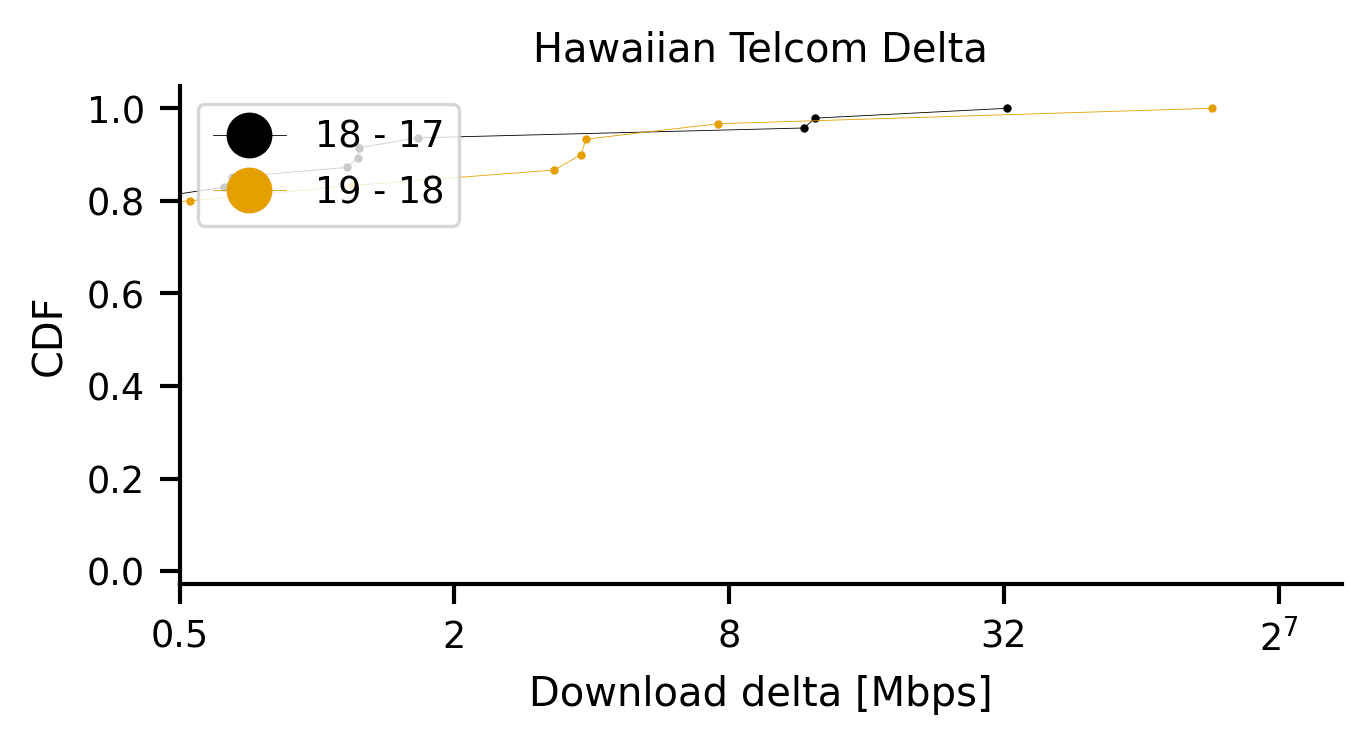

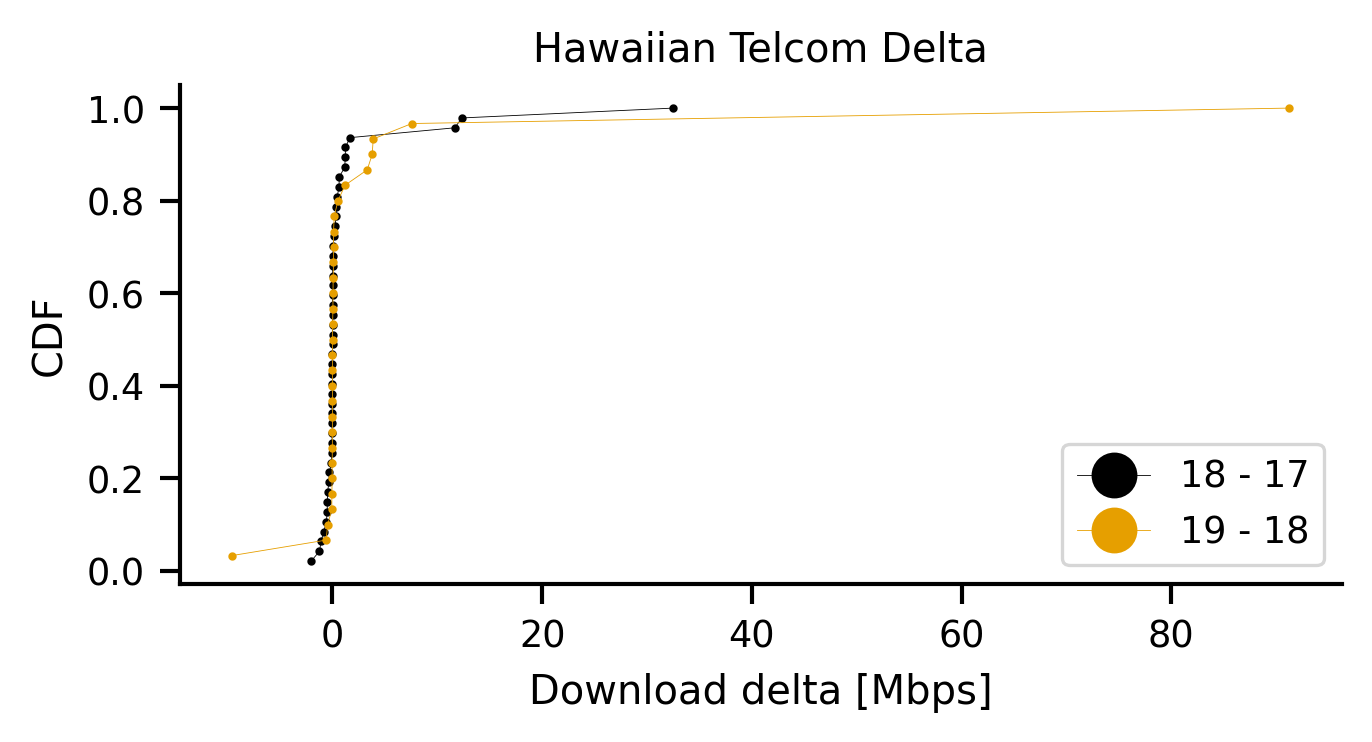

In [164]:
df_hit_carry_metadata_forward = df[(df.year.isin(['2019', '2018', '2017'])) & (df.unit_id.isin(hit_probes_carry_fwd))].merge(df_tech[df_tech.year == '2017'], on='unit_id')


df_yearly_med = df_hit_carry_metadata_forward.groupby(['unit_id', 'year_x'], as_index=False).agg({'download':'first', 'med_bytes_sec':'median'})
df_yearly_med.download = pd.to_numeric(df_yearly_med.download)
df_17_18 = df_yearly_med[df_yearly_med.year_x == '2017'].merge(df_yearly_med[df_yearly_med.year_x == '2018'], on='unit_id')
df_17_18['delta'] = df_17_18.med_bytes_sec_y - df_17_18.med_bytes_sec_x

df_18_19 = df_yearly_med[df_yearly_med.year_x == '2018'].merge(df_yearly_med[df_yearly_med.year_x == '2019'], on='unit_id')
df_18_19['delta'] = df_18_19.med_bytes_sec_y - df_18_19.med_bytes_sec_x



for log in [True, False]:
    
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5,2.2))
    plt.rcParams['axes.formatter.min_exponent'] = 14
    #fig.subplots_adjust(hspace=.3)
    #fig = plt.figure(figsize=(10,2))
    #fig.subplots_adjust(hspace=0.3)#, wspace=0.4)
    #ax = axs[0] #= fig.add_subplot(121)
    #ax2 = axs[1] #= fig.add_subplot(122, sharey=ax, sharex=ax)
    if log:
        ax.set_xscale('log', basex=2)
    
    lnwidth = 0.2
    mrksize = 2

    dfplt = make_cdf(df_17_18['delta'])
    dfplt.plot(y="delta", ax=ax, label='18 - 17', marker='.', markersize=mrksize, drawstyle="default", lw=lnwidth)
    
    dfplt = make_cdf(df_18_19['delta'])
    dfplt.plot(y="delta", ax=ax, label='19 - 18', marker='.', markersize=mrksize, drawstyle="default", lw=lnwidth)
        

        #df_tmp = df_6_new[df_6_new.technology == tech]["med_bytes_sec"]
        #if len(df_tmp) > 0:
        #    dfplt = make_cdf(df_tmp)
        #    dfplt.plot(y="med_bytes_sec", ax=ax2, label=tech, marker='.', markersize=mrksize, drawstyle="default", lw=lnwidth, color=colors[tech])

        
    if log:
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: better_general_format(x)))
        #ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: better_general_format(x)))
        #ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        #ax2.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
        #ax.xaxis.set_major_formatter(LogFormatterMathtext(base=2))
        #ax2.xaxis.set_major_formatter(LogFormatterMathtext(base=2))

    
    #ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: human_format(x)))
    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    
    if log:
        ax.legend(loc='upper left', ncol=1, markerscale=10)#, bbox_to_anchor=(.8, -.5))
    else:
        ax.legend(loc='lower right', ncol=1, markerscale=10)#, bbox_to_anchor=(.8, -.5))
    
    if log:
        ax.set_xlim(left=2**-1)
    
    ax.set_title("Hawaiian Telcom Delta")
    ax.set_xlabel("Download delta [Mbps]")
    ax.set_ylabel("CDF")
    '''
    ax2.spines['right'].set_color('none')
    ax2.spines['top'].set_color('none')
    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.spines['bottom'].set_position(('axes', -0.0))
    ax2.spines['left'].set_position(('axes', -0.0))

    
    ax2.set_title("IPv6 Downstream Throughput 2019")
    
    
    ax2.set_xlabel("Download [Mbps]")

    
    ax2.set_ylabel("CDF")
'''
    #if log:
    #    fig.savefig('HTTP_GET_MT/HTTP-GET-MT-CDF-by-ACCESSTECH-IPv6-no-Satellite-log.pdf', format='pdf', bbox_inches='tight')
    #else:
    #    fig.savefig('HTTP_GET_MT/HTTP-GET-MT-CDF-by-ACCESSTECH-IPv6-no-Satellite.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [165]:
df_18_19[(df_18_19.delta > 15) | (df_18_19.delta < -15)].sort_values('delta')

,unit_id,year_x_x,download_x,med_bytes_sec_x,year_x_y,download_y,med_bytes_sec_y,delta
5,995125,2018,7,2.824826,2019,7,94.064132,91.239306


In [166]:
hit_probes_carry_fwd.remove(995125)



In [167]:
df_17_18[(df_17_18.delta > 15) | (df_17_18.delta < -15)]

,unit_id,year_x_x,download_x,med_bytes_sec_x,year_x_y,download_y,med_bytes_sec_y,delta
8,995121,2017,11,8.8596,2018,11,41.36772,32.50812


In [ ]:
hit_probes_carry_fwd.remove(995121)